### Package & function load

In [1665]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, make_scorer, precision_recall_curve, roc_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt.style.use('seaborn-white')
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline
import copy

from sklearn.decomposition import PCA

In [1657]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [389]:
# data = arff.loadarff('/Users/ridha.soedarsono/ds/metis/metis-w4/data/5year.arff')
# df = pd.DataFrame(data[0])
# df.columns = ['net profit / total assets ', 'total liabilities / total assets ', 'working capital / total assets ', 'current assets / short-term liabilities ', '[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365 ', 'retained earnings / total assets ', 'EBIT / total assets ', 'book value of equity / total liabilities ', 'sales / total assets ', 'equity / total assets ', '(gross profit + extraordinary items + financial expenses) / total assets ', 'gross profit / short-term liabilities ', '(gross profit + depreciation) / sales ', '(gross profit + interest) / total assets ', '(total liabilities * 365) / (gross profit + depreciation) ', '(gross profit + depreciation) / total liabilities ', 'total assets / total liabilities ', 'gross profit / total assets ', 'gross profit / sales ', '(inventory * 365) / sales ', 'sales (n) / sales (n-1) ', 'profit on operating activities / total assets ', 'net profit / sales ', 'gross profit (in 3 years) / total assets ', '(equity - share capital) / total assets ', '(net profit + depreciation) / total liabilities ', 'profit on operating activities / financial expenses ', 'working capital / fixed assets ', 'logarithm of total assets ', '(total liabilities - cash) / sales ', '(gross profit + interest) / sales ', '(current liabilities * 365) / cost of products sold ', 'operating expenses / short-term liabilities ', 'operating expenses / total liabilities ', 'profit on sales / total assets ', 'total sales / total assets ', '(current assets - inventories) / long-term liabilities ', 'constant capital / total assets ', 'profit on sales / sales ', '(current assets - inventory - receivables) / short-term liabilities ', 'total liabilities / ((profit on operating activities + depreciation) * (12/365)) ', 'profit on operating activities / sales ', 'rotation receivables + inventory turnover in days ', '(receivables * 365) / sales ', 'net profit / inventory ', '(current assets - inventory) / short-term liabilities ', '(inventory * 365) / cost of products sold ', 'EBITDA (profit on operating activities - depreciation) / total assets ', 'EBITDA (profit on operating activities - depreciation) / sales ', 'current assets / total liabilities ', 'short-term liabilities / total assets ', '(short-term liabilities * 365) / cost of products sold) ', 'equity / fixed assets ', 'constant capital / fixed assets ', 'working capital ', '(sales - cost of products sold) / sales ', '(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation) ', 'total costs /total sales ', 'long-term liabilities / equity ', 'sales / inventory ', 'sales / receivables ', '(short-term liabilities *365) / sales ', 'sales / short-term liabilities ', 'sales / fixed assets', 'class']
# df.iloc[:,-1] = df.iloc[:,-1].str.decode('UTF-8')

In [1634]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7)):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize, dpi=100)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=18)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=18)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    #return fig

In [914]:
# CV Scoring with SMOTE
def cv_smote_score(model, X, y, cv=5, random_state=None):
    
    ssX = StandardScaler()
    pca = PCA(0.9)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    recalls = []
    precisions = []
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        X_train_cv_sc = ssX.fit_transform(X_train_cv)
        X_test_cv_sc = ssX.transform(X_test_cv)
        
        #X_train_cv_sc = pca.fit_transform(X_train_cv_sc)
        #X_test_cv_sc = pca.transform(X_test_cv_sc)
        
        X_res, y_res = SMOTEENN().fit_sample(X_train_cv_sc,y_train_cv)
        X_res, y_res = X_train_cv_sc,y_train_cv
        
        model.fit(X_res, y_res)
        y_predict = model.predict(X_test_cv_sc)
        
        recalls.append(recall_score(y_test_cv, y_predict))
        f1_scores.append(f1_score(y_test_cv, y_predict))
        precisions.append(precision_score(y_test_cv, y_predict))

    return pd.DataFrame([np.mean(recalls), np.mean(precisions), np.mean(f1_scores)], columns=['Score'], index=['Avg. recall', 'Avg. precision', 'Avg. F1 score'])

In [915]:
# CV Scoring with Sampler & getting feature importances
def cv_smote_feat(model, X, y, cv=5, random_state=None):
    
    ssX = StandardScaler()
    pca = PCA(0.95)
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    recalls = []
    precisions = []
    f1_scores = []
    feature_imp = []

    for train_index, test_index in skf.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        
        X_train_cv_sc = ssX.fit_transform(X_train_cv)
        X_test_cv_sc = ssX.transform(X_test_cv)
        
        #X_train_cv_sc = pca.fit_transform(X_train_cv_sc)
        #X_test_cv_sc = pca.transform(X_test_cv_sc)
        
        X_res, y_res = SMOTEENN().fit_sample(X_train_cv_sc,y_train_cv)
        X_res, y_res = X_train_cv_sc, y_train_cv

        model.fit(X_res, y_res)
        y_predict = model.predict(X_test_cv_sc)
        
        recalls.append(recall_score(y_test_cv, y_predict))
        f1_scores.append(f1_score(y_test_cv, y_predict))
        precisions.append(precision_score(y_test_cv, y_predict))
        feature_imp.append(model.feature_importances_)
    
    scores = pd.DataFrame([np.mean(recalls), np.mean(precisions), np.mean(f1_scores)], columns=['Score'], index=['Avg. Recall', 'Avg. Precision', 'Avg. F1'])
    features = pd.DataFrame(feature_imp, columns=X_train.columns)
    features = features.mean().sort_values(ascending=False)
    
    return scores, features

### Data load

In [878]:
df = pd.read_csv('/Users/ridha.soedarsono/ds/metis/metis-w4/financial-distress.zip')

In [879]:
df.loc[df['Financial Distress'] >= -0.5, 'Financial Distress'] = 0
df.loc[df['Financial Distress'] != 0, 'Financial Distress'] = 1
df['Financial Distress'] = df['Financial Distress'].astype(int)

In [880]:
#Dropping categorial variables
df.drop(['x80'], axis=1, inplace=True)

In [881]:
# #Dummifying categorical variables

# dummy_cols = {}

# for i in range(1,len(df.x80.unique())+1):
#     dummy_cols[i] = f'x80_{i}'
    
# df_dummy = pd.get_dummies(df['x80'])
# df_dummy.rename(columns=dummy_cols, inplace=True)

# df.drop(['x80'], axis=1, inplace=True)
# df = df.join(df_dummy)

### Train/test split & scale

In [882]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,3:], df['Financial Distress'], test_size=0.3, random_state=10, stratify=df['Financial Distress'])

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [1574]:
1/25*100

4.0

In [1571]:
(136/3682)*100

3.6936447582835417

In [883]:
print('Bankruptcy proportion check')
print(f'Test  : {y_test.value_counts()[1] / sum(y_test.value_counts().values)*100:2.4} %')
print(f'Train : {y_train.value_counts()[1] / sum(y_train.value_counts().values)*100:2.4} %')

Bankruptcy proportion check
Test  : 3.721 %
Train : 3.696 %


# Preprocessing

### Feature Engineering: only log is taken (sqrt & dummy dropped)

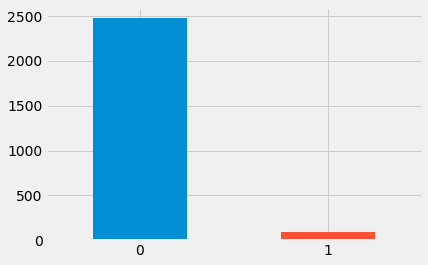

In [884]:
y_train.value_counts().plot(kind='bar', rot=0)

In [1131]:
pca = PCA(2)

X_ = pca.fit_transform(df.iloc[:,3:])
#y_ = pca.transform(df['Financial Distress'])

X_[:,0]

array([[-365901.58941968,  -68780.0947817 ],
       [-365900.51722503,  -68761.52195321],
       [-365900.61190243,  -68712.76834104],
       ...,
       [1046417.54461526, -101706.80730736],
       [-365872.61615324,  -68597.59111881],
       [-365885.63734029,  -68006.75963101]])

In [885]:
# X_train['x80'] = X_train['x80'].astype(str)
# df_x80 = pd.DataFrame(list(zip(X_train.x80,y_train)), columns=['x80','FinancialDistress'])
# df_x80[df_x80.FinancialDistress == 1].x80.value_counts()#.sort_values(axis=0)

In [886]:
# Xy_train = X_train.join(y_train)
# Xy_train.head()

In [887]:
# for col in Xy_train.columns:
#     if col == 'Financial Distress' or 'x80' in col:
#         next
#     else:
#         Xy_train['log_' + col] = np.log(X_train[col])
#         Xy_train['sqrt_' + col] = np.sqrt(X_train[col])
    
# correlations = Xy_train.corr()['Financial Distress'].abs().sort_values(ascending=False)
# correlations.head(15)

In [888]:
#Taking only log-transformed
for col in X_train.columns:
    if col == 'Financial Distress' or 'x80' in col:
        next
    else:
        X_train['log_' + col] = np.log(X_train[col])

#Taking only log-transformed
for col in X_test.columns:
    if col == 'Financial Distress' or 'x80' in col:
        next
    else:
        X_test['log_' + col] = np.log(X_test[col])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


### Feature selection: removing collinearity

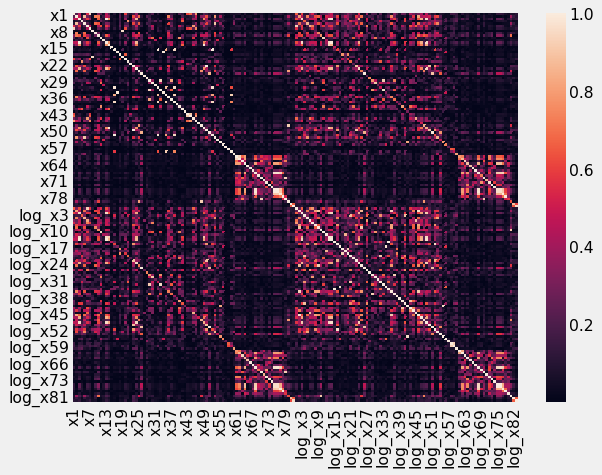

In [889]:
plt.subplots(figsize=(8,6),dpi=80)
sns.heatmap(X_train.corr().abs())

In [890]:
# Create filter mask, and remove half-pair of features with corr > 0.8
upper = X_train.corr().where(np.triu(np.ones(X_train.corr().shape), k=1).astype(np.bool))

mask = []
for col in upper.columns:
    if any(upper[col] > 0.8) >= 1:
        mask.append(col)

X_train.drop(mask, axis=1, inplace=True)
X_test.drop(mask, axis=1, inplace=True)
print(f'{len(mask)} columns dropped for collinearity:')
print(mask)

71 columns dropped for collinearity:
['x5', 'x7', 'x24', 'x34', 'x35', 'x37', 'x38', 'x44', 'x49', 'x51', 'x52', 'x53', 'x62', 'x64', 'x75', 'x76', 'x77', 'x81', 'log_x1', 'log_x3', 'log_x5', 'log_x6', 'log_x9', 'log_x11', 'log_x13', 'log_x14', 'log_x20', 'log_x21', 'log_x23', 'log_x24', 'log_x25', 'log_x26', 'log_x30', 'log_x33', 'log_x34', 'log_x36', 'log_x37', 'log_x40', 'log_x41', 'log_x42', 'log_x45', 'log_x46', 'log_x47', 'log_x48', 'log_x49', 'log_x50', 'log_x51', 'log_x52', 'log_x53', 'log_x55', 'log_x59', 'log_x60', 'log_x62', 'log_x63', 'log_x64', 'log_x65', 'log_x66', 'log_x67', 'log_x68', 'log_x70', 'log_x71', 'log_x72', 'log_x73', 'log_x74', 'log_x75', 'log_x76', 'log_x77', 'log_x78', 'log_x81', 'log_x82', 'log_x83']


In [891]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

mask = []
for col in X_train.columns:
    if any(X_train[col].isna()):
        mask.append(col)
        
X_train.drop(mask, axis=1, inplace=True)
X_test.drop(mask, axis=1, inplace=True)
print(f'{len(mask)} columns dropped for NaNs:')
print(mask)

20 columns dropped for NaNs:
['log_x2', 'log_x8', 'log_x10', 'log_x12', 'log_x16', 'log_x17', 'log_x19', 'log_x27', 'log_x28', 'log_x29', 'log_x31', 'log_x35', 'log_x39', 'log_x44', 'log_x56', 'log_x57', 'log_x58', 'log_x61', 'log_x69', 'log_x79']


### Feature selection: PCA

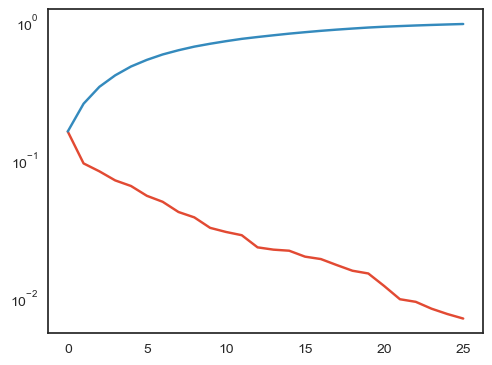

In [1673]:
ssX = StandardScaler()
pca = PCA(0.95)

X_train_ = ssX.fit_transform(X_train)
pca = pca.fit(X_train_)

X_res, y_res = RandomUnderSampler().fit_sample(X_train_,y_train)

pca1 = pca.fit(X_res)

plt.figure(dpi=100, figsize=(5,4))
plt.semilogy(pca1.explained_variance_ratio_);
plt.semilogy(pca1.explained_variance_ratio_.cumsum());
#plt.xlim('')
#plt.ylim(10e-4,1)
#plt.xlim(0,60)

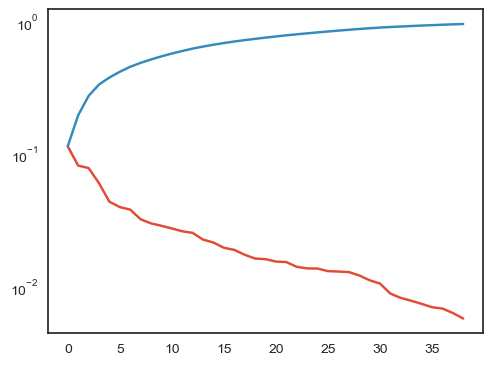

In [1580]:
ssX = StandardScaler()
pca = PCA(0.95)

X_train_ = ssX.fit_transform(X_train)
pca = pca.fit(X_train_)

X_res, y_res = SMOTEENN().fit_sample(X_train_,y_train)

pca = pca.fit(X_train_)


plt.figure(dpi=100, figsize=(5,4))
plt.semilogy(pca.explained_variance_ratio_);
plt.semilogy(pca.explained_variance_ratio_.cumsum());
#plt.xlim('')
#plt.ylim(10e-4,1)
#plt.xlim(0,60)

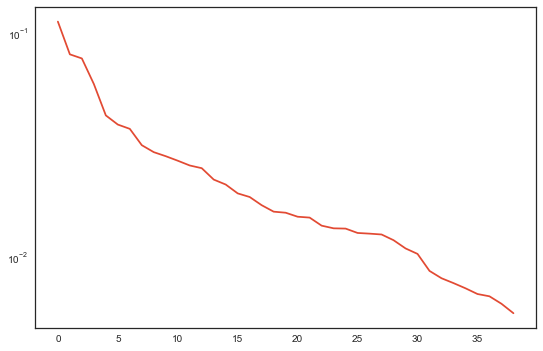

In [1575]:
plt.semilogy(pca.explained_variance_ratio_);

### Feature selection: random forest for feature importances

In [341]:
# NO PCA
# model = RandomForestClassifier()
# ssX = StandardScaler()
# pca = PCA(0.95)
# sampler = SMOTE()

# X_train_ = ssX.fit_transform(X_train)
# X_train_ = pca.fit_transform(X_train_)
# X_train_, y_train_ = sampler.fit_sample(X_train_, y_train)
# model.fit(X_train_, y_train_)
# len(model.feature_importances_)

39

In [856]:
# selection in CV
features_avg = []

for _ in range(10):
    scores, features = cv_smote_feat(RandomForestClassifier(n_estimators=100, class_weight={1:10}), X_train, y_train)
    features_avg.append(features)
    
features_avg = pd.DataFrame(features_avg)
features_avg = features_avg.mean()
featuresRF = features_avg.sort_values(ascending = False)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Learning curve

In [1481]:
# Learning curve & plot function: score vs. # of features

def feature_scorer(model, X, y, model_scorer, num_features):
    feat_score = pd.DataFrame()
    
    for feature in range(num_features):
        dfs = pd.DataFrame()
        for i in range(10):
            df = cv_smote_score(model, X[model_scorer.index[0:feature+1]], y)

#             ssX = StandardScaler()
#             #pca = PCA(0.95)
#             skf = StratifiedKFold(n_splits=5, shuffle=True)

#             recalls = []
#             precisions = []
#             f1_scores = []

#             for train_index, test_index in skf.split(X, y):
#                 X_train_cv, X_test_cv = X.iloc[train_index,:], X.iloc[test_index,:]
#                 y_train_cv, y_test_cv = y[train_index], y[test_index]

#                 X_train_cv_sc = ssX.fit_transform(X_train_cv)
#                 X_test_cv_sc = ssX.transform(X_test_cv)

#                 #X_train_cv_sc = pca.fit_transform(X_train_cv_sc)
#                 #X_test_cv_sc = pca.transform(X_test_cv_sc)

#                 X_res, y_res = SMOTEENN().fit_sample(X_train_cv_sc,y_train_cv)
                
#                 X_res = pd.DataFrame(X_res, columns=X_train.columns)
#                 X_test_cv_sc = pd.DataFrame(X_test_cv_sc, columns=X_train.columns)

#                 model.fit(X_res.loc[:,model_scorer.index[0:feature+1]], y_res)
#                 y_predict = model.predict(X_test_cv_sc.loc[:,model_scorer.index[0:feature+1]])

#                 recalls.append(recall_score(y_test_cv, y_predict))
#                 f1_scores.append(f1_score(y_test_cv, y_predict))
#                 precisions.append(precision_score(y_test_cv, y_predict))

#             df = pd.DataFrame([np.mean(recalls), np.mean(precisions), np.mean(f1_scores)], columns=['Score'], index=['Avg. Recall', 'Avg. Precision', 'Avg. F1'])
            dfs[i] = df['Score']

        dfs['Avg. Score'] = dfs.mean(axis=1)    
        dfs = pd.DataFrame(dfs['Avg. Score'])

        feat_score[f'Top{feature+1} feat'] = dfs['Avg. Score']
    
    return feat_score


def plot_learning_curve(feat_score):
    plt.figure(dpi=100, figsize=(6,4))
    plt.plot(range(1,len(feat_score.iloc[0,:])+1), feat_score.loc['Avg. recall',:], label='Recall')
    plt.plot(range(1,len(feat_score.iloc[0,:])+1), feat_score.loc['Avg. F1 score',:], label='F1' )
    plt.xticks(np.arange(1,len(feat_score.iloc[0,:])+1,2))
    plt.xlabel('# of Features')
    plt.ylabel('Score')
    plt.legend()


In [916]:
#rf_featuresXG = feature_scorer(RandomForestClassifier(n_estimators=100), X_train, y_train, featuresXG, 25)
#rf_featuresRF2 = feature_scorer(RandomForestClassifier(n_estimators=100), X_train, y_train, featuresRF2, 20)
#xg_featuresXG = feature_scorer(XGBClassifier(), X_train, y_train, featuresXG, 25)
#xg_featuresRF = feature_scorer(XGBClassifier(), featuresRF, 25)

Text(0.5,1,'Learning Curve')

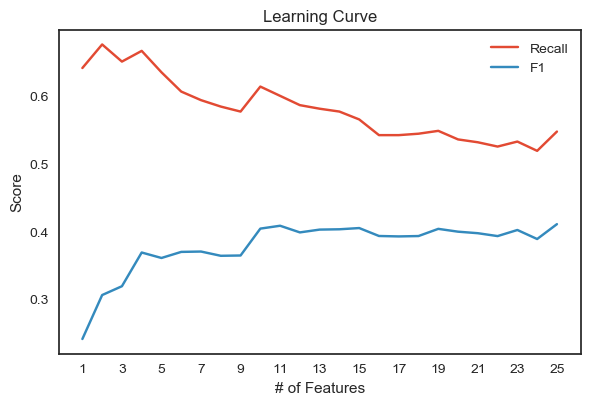

In [1563]:
plot_learning_curve(features_score)
plt.title('Learning Curve')

In [1593]:
coef = pd.DataFrame(featuresXG[:10], columns=['Coefficient'])
coef.to_csv('./coef.csv')

# Modelling

### XGBoost

In [1025]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('sample', RandomOverSampler()),
    ('xg', XGBClassifier())
])

param_grid = {
    'xg__n_estimators': [2000],
    'xg__max_depth': [10],
    'xg__learning_rate': [0.01],
    'xg__gamma': [1,0.1],
    'xg__reg_lambda': [0,0.1],
    'xg__reg_alpha': [0.1,1]
}

gridXG = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridXG.fit(X_train[featuresXG.index[0:10]], y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sample', RandomOverSampler(random_state=None, ratio='auto')), ('xg', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'xg__n_estimators': [2000], 'xg__max_depth': [10], 'xg__learning_rate': [0.01], 'xg__gamma': [1, 0.1], 'xg__reg_lambda': [0, 0.1], 'xg__reg_alpha': [0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [1026]:
gridXG.best_params_

{'xg__gamma': 1,
 'xg__learning_rate': 0.01,
 'xg__max_depth': 10,
 'xg__n_estimators': 2000,
 'xg__reg_alpha': 1,
 'xg__reg_lambda': 0}

In [1027]:
gridXG.best_score_

0.40320134227483245

In [1042]:
y_pred[:,1] >= 0.4

array([False,  True, False, ..., False, False, False])

0.6585365853658537
0.2571428571428571
0.3698630136986301


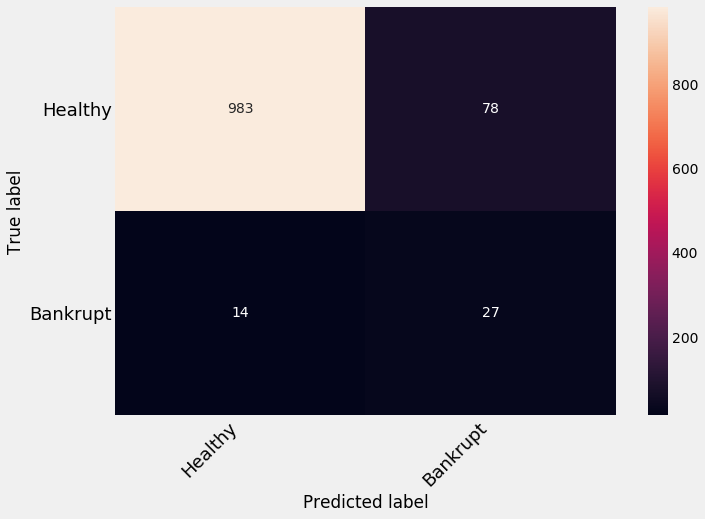

In [1049]:
y_pred = (gridXG.predict_proba(X_test[featuresXG.index[:10]])[:,1] >= 0.2)
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.4878048780487805
0.3636363636363637


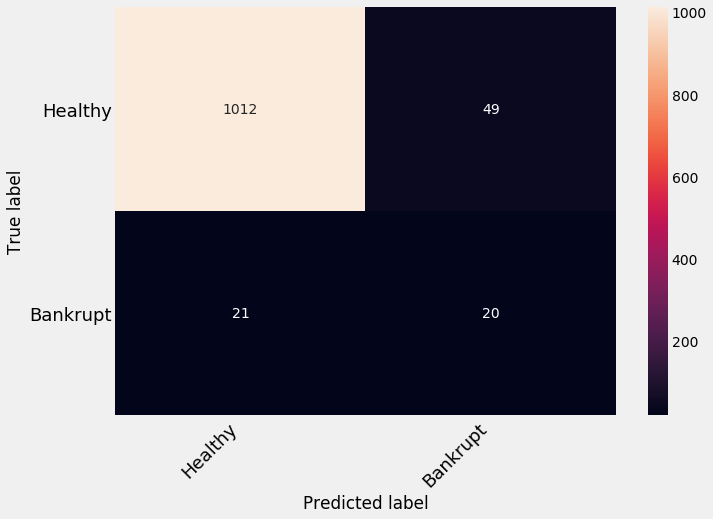

In [758]:
model = XGBClassifier(gamma=1, learning_rate=0.01, max_depth=10, n_estimators=1500, reg_alpha=1, reg_lambda=0)
ssX = StandardScaler()

X_train_ = ssX.fit_transform(X_train[featuresXG.index[:10]])
X_test_ = ssX.transform(X_test[featuresXG.index[:10]])

X_train_, y_train_ = RandomOverSampler().fit_sample(X_train_, y_train)

model.fit(X_train_, y_train_)
y_pred = model.predict(X_test_)
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

### Random Forest

In [817]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('smote', SMOTE()),
    ('rf', RandomForestClassifier())
])

param_grid = {
    'rf__n_estimators': [2000],
    'rf__max_depth': [15],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_split': [2,5],
    'rf__min_samples_leaf': [2,5],
}

gridRF = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridRF.fit(X_train[featuresXG.index[:10]], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'rf__n_estimators': [2000], 'rf__max_depth': [15], 'rf__max_features': ['auto', 'sqrt'], 'rf__min_samples_split': [2, 5], 'rf__min_samples_leaf': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

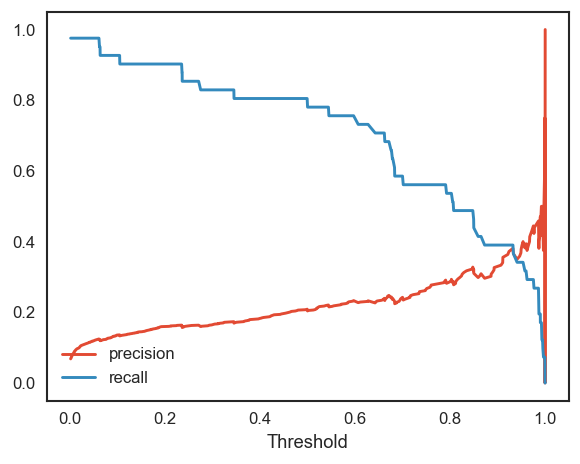

In [1152]:
y_pred_proba = gridRF.predict_proba(X_test[featuresXG.index[:10]])
precision_curve_RF, recall_curve_RF, threshold_curve_RF = precision_recall_curve(y_test, y_pred_proba[:,1])

plt.figure(figsize=(5,4), dpi=120)
plt.plot(threshold_curve_RF, precision_curve_RF[1:],label='precision')
plt.plot(threshold_curve_RF, recall_curve_RF[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');

Text(0,0.5,'Precision')

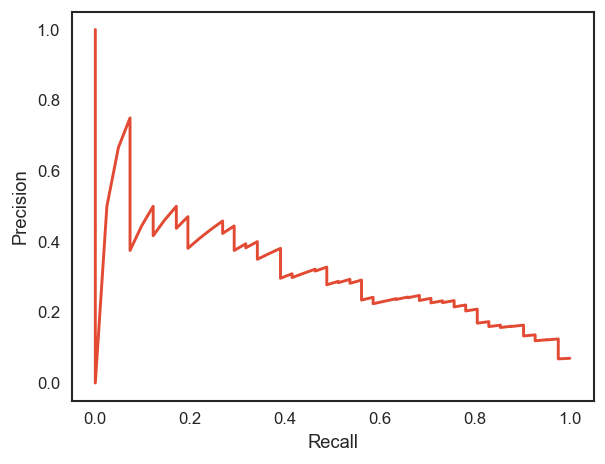

In [1154]:
grid

y_pred_proba = gridRF.predict_proba(X_test[featuresXG.index[:10]])
precision_curve_RF, recall_curve_RF, threshold_curve_RF = precision_recall_curve(y_test, y_pred_proba[:,1])

plt.figure(figsize=(5,4), dpi=120)
plt.plot(recall_curve_RF, precision_curve_RF)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [779]:
gridRF.best_params_

{'rf__max_depth': 15,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 2000}

0.8048780487804879
0.2088607594936709
0.3316582914572864


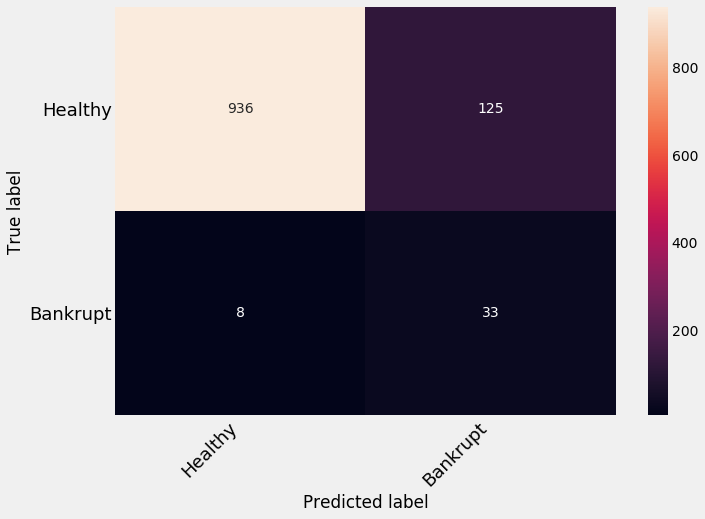

In [1056]:
y_pred = (gridRF.predict_proba(X_test[featuresXG.index[:10]])[:,1] >= 0.5)
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

0.7317073170731707
0.36585365853658536


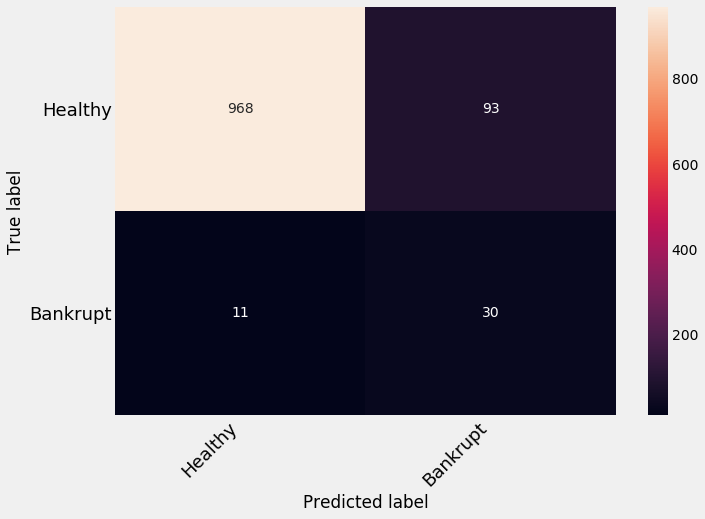

In [897]:
model = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=2000)
ssX = StandardScaler()

X_train_ = ssX.fit_transform(X_train)
X_test_ = ssX.transform(X_test)

X_train_, y_train_ = SMOTEENN().fit_sample(X_train_, y_train)

model.fit(X_train_, y_train_)
y_pred = model.predict(X_test_)
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

### SGD

In [1173]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDClassifier())
])

param_grid = {
    'sgd__class_weight': [{1:17}],
    'sgd__alpha': [0.00001, 0.0001, 0.001],
    'sgd__tol': [1e-3],
    'sgd__n_iter': [1000]
}

gridSGD = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridSGD.fit(X_train[featuresXG.index[:10]], y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: 

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'sgd__class_weight': [{1: 17}], 'sgd__alpha': [1e-05, 0.0001, 0.001], 'sgd__tol': [0.001], 'sgd__n_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [1174]:
gridSGD.best_params_

{'sgd__alpha': 0.001,
 'sgd__class_weight': {1: 17},
 'sgd__n_iter': 1000,
 'sgd__tol': 0.001}

0.7804878048780488
0.1702127659574468
0.2794759825327511


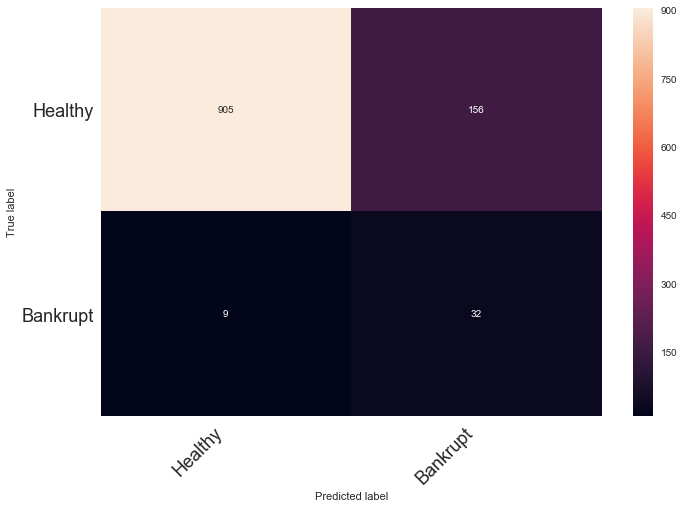

In [1175]:
y_pred = gridSGD.predict(X_test[featuresXG.index[:10]])
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9024390243902439
0.08240534521158129
0.15102040816326529


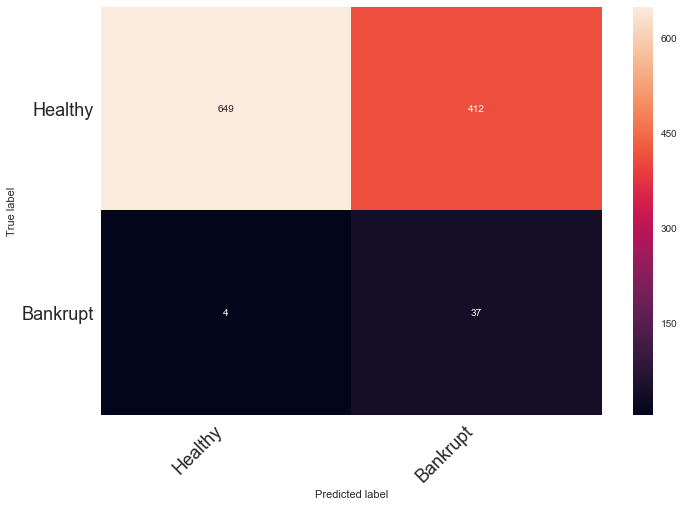

In [1156]:
model = SGDClassifier(class_weight={1:15})
ssX = StandardScaler()

X_train_ = ssX.fit_transform(X_train[featuresXG.index[:10]])
X_test_ = ssX.transform(X_test[featuresXG.index[:10]])

#X_train_, y_train_ = RandomUnderSampler().fit_sample(X_train_, y_train)

model.fit(X_train_, y_train)
y_pred = model.predict(X_test_)
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

### KNN

In [1205]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('sampler', SMOTE()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [5,15,30]
}

gridKNN = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridKNN.fit(X_train[featuresXG.index[:10]], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sampler', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'knn__weights': ['uniform', 'distance'], 'knn__n_neighbors': [5, 15, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [1206]:
gridKNN.best_score_

0.2626220937438776

0.8292682926829268
0.15668202764976957
0.2635658914728682


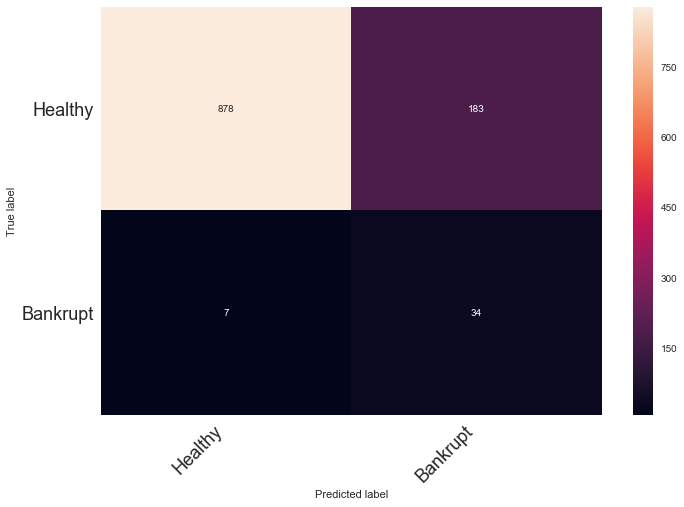

In [1207]:
y_pred = gridKNN.predict(X_test[featuresXG.index[:10]])
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

0.8048780487804879
0.1625615763546798
0.2704918032786885


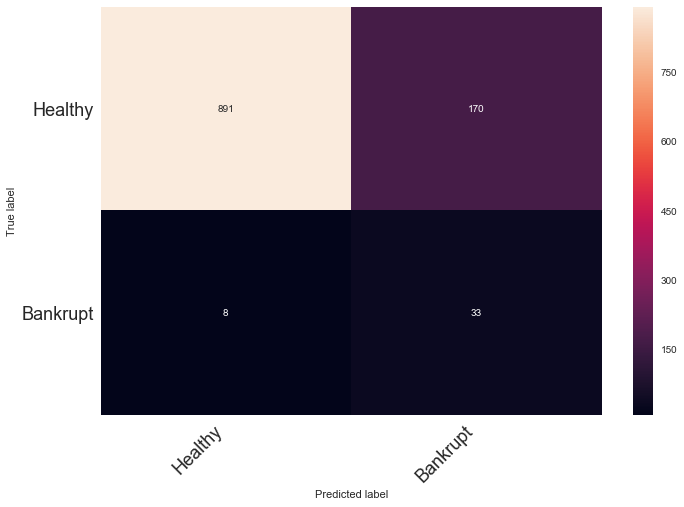

In [1202]:
model = KNeighborsClassifier()
ssX = StandardScaler()

X_train_ = ssX.fit_transform(X_train[featuresXG.index[:10]])
X_test_ = ssX.transform(X_test[featuresXG.index[:10]])

X_train_, y_train_ = SMOTEENN().fit_sample(X_train_, y_train)

model.fit(X_train_, y_train_)
y_pred = model.predict(X_test_)
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

### Logistic Regression

In [1161]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression())
])

param_grid = {
    'lr__class_weight': [{1:15}],
    'lr__C': [0.01, 0.1, 1]
}

gridLR = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridLR.fit(X_train[featuresXG.index[:10]], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'lr__class_weight': [{1: 15}], 'lr__C': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

0.8048780487804879
0.1952662721893491
0.3142857142857142


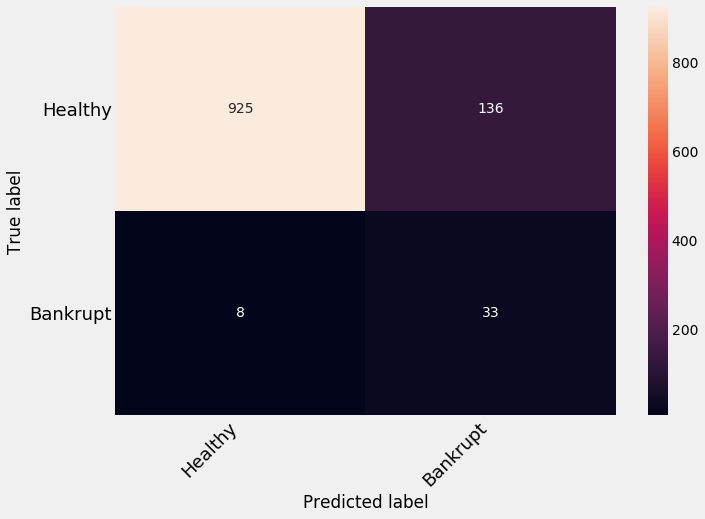

In [965]:
y_pred = gridLR.predict(X_test[featuresXG.index[:10]])
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

0.8048780487804879
0.3142857142857142


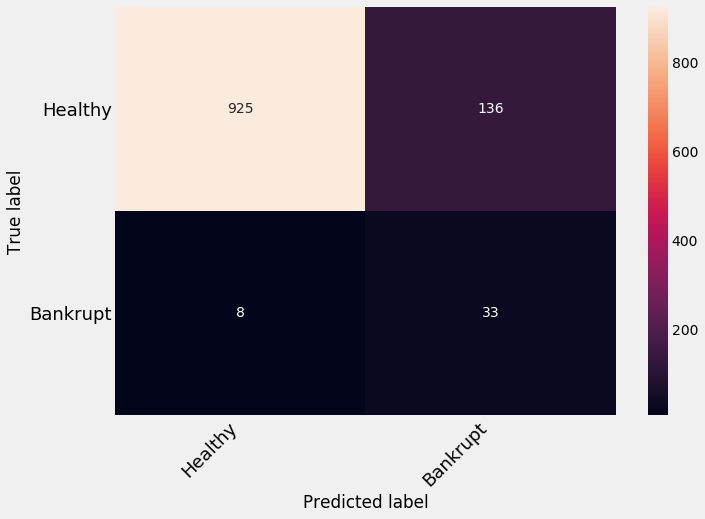

In [961]:
model = LogisticRegression(class_weight={1:15})
ssX = StandardScaler()

X_train_ = ssX.fit_transform(X_train[featuresXG.index[:10]])
X_test_ = ssX.transform(X_test[featuresXG.index[:10]])

#X_train_, y_train_ = ADASYN().fit_sample(X_train_, y_train)

model.fit(X_train_, y_train)
y_pred = model.predict(X_test_)
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

### SVM

In [1279]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC())
])

param_grid = {
    'svc__C': [0.001, 0.01,0.1,1,10],
    'svc__gamma' : [0.001,0.01,0.1,1],
    'svc__degree' : [2,3],
    'svc__probability' : [True],
    'svc__class_weight': [{1:13}]
}

gridSVC = GridSearchCV(pipe, param_grid, scoring='recall', n_jobs=-1, cv=5)
gridSVC.fit(X_train[featuresXG.index[:10]], y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10], 'svc__gamma': [0.001, 0.01, 0.1, 1], 'svc__degree': [2, 3], 'svc__probability': [True], 'svc__class_weight': [{1: 13}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [1280]:
gridSVC.best_params_

{'svc__C': 1,
 'svc__class_weight': {1: 13},
 'svc__degree': 2,
 'svc__gamma': 0.01,
 'svc__probability': True}

0.7560975609756098
0.21232876712328766
0.3315508021390374


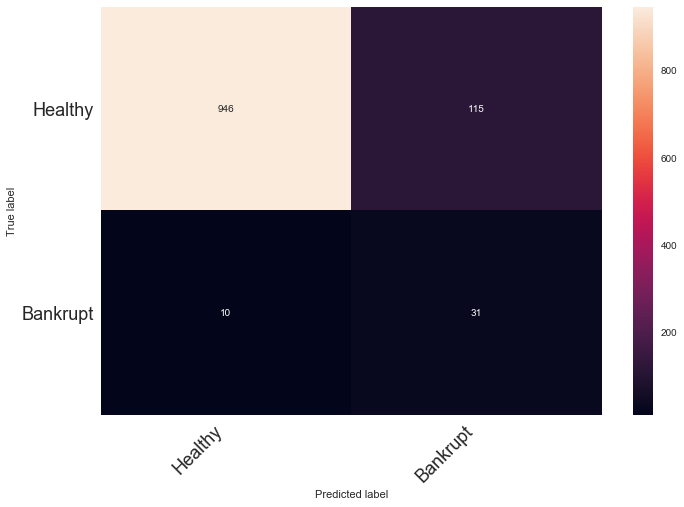

In [1281]:
y_pred = gridSVC.predict(X_test[featuresXG.index[:10]])
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

Text(0.5,1,'Precision-recall curve')

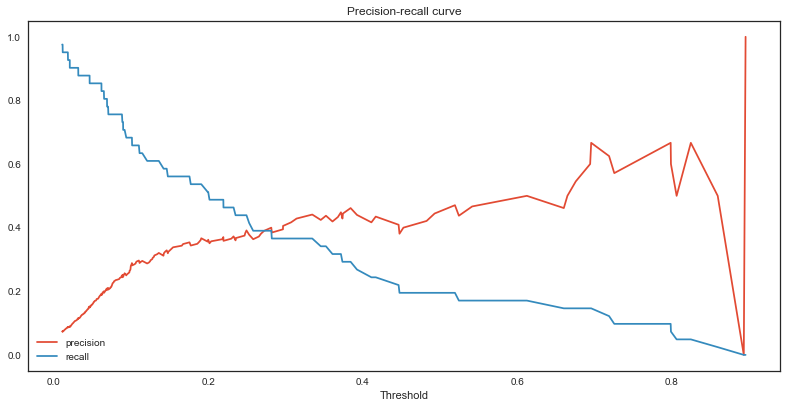

In [1282]:
y_pred_proba = gridSVC.predict_proba(X_test[featuresXG.index[:10]])
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, y_pred_proba[:,1])

plt.figure(figsize=(12,6))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision-recall curve')

### Best Model

0.8292682926829268
0.2138364779874214
0.33999999999999997


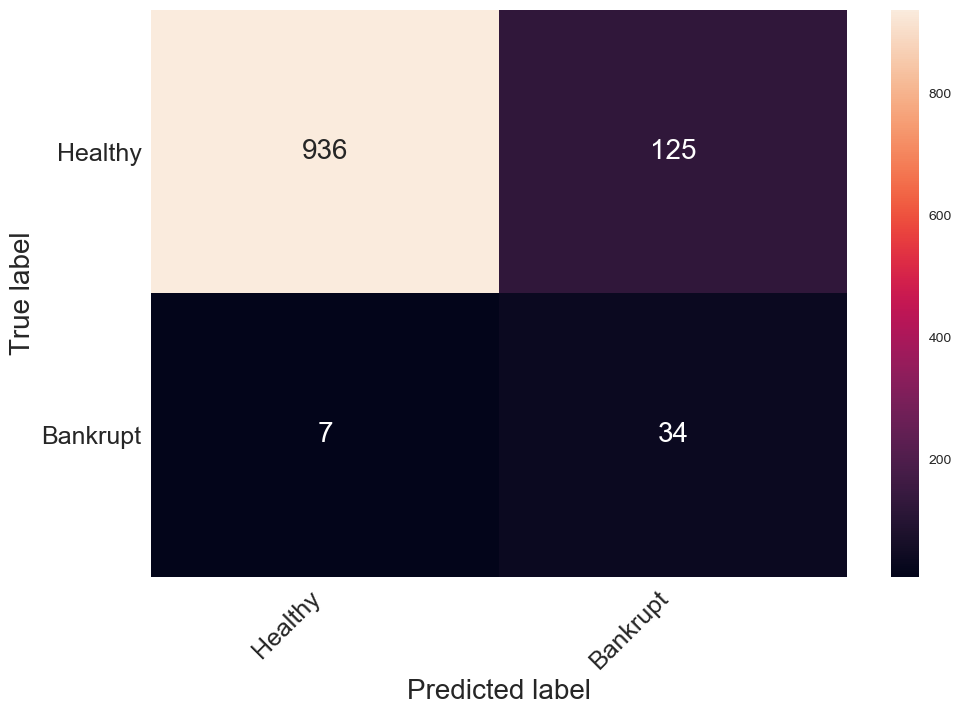

In [1635]:
gridSVC = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(gamma=0.05, probability=True, class_weight={1:13}))
])

# model = SVC(class_weight={1:13}, probability=True, gamma=0.05)
# ssX = StandardScaler()

# X_train_ = ssX.fit_transform(X_train[featuresXG.index[:10]])
# X_test_ = ssX.transform(X_test[featuresXG.index[:10]])

#X_train_, y_train_ = ADASYN().fit_sample(X_train_, y_train)

gridSVC.fit(X_train[features_coef.index[:10]], y_train)
y_pred = gridSVC.predict(X_test[features_coef.index[:10]])
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print_confusion_matrix(confusion_matrix(y_test, y_pred), ['Healthy', 'Bankrupt'])

In [1630]:
34/(34+125)

0.2138364779874214

In [1322]:
gridSVC.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight={1: 13}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])>

# Plots

### Accuracy, Recall, F1 scores

In [1462]:
grids = [gridSVC, gridRF, gridLR, gridKNN]
models = ['SVC', 'RandomForest', 'LogisticRegression', 'KNN']
x = np.array(range(3))

svcs = []
rfs = []
lrs = []
knns = []

y_pred = gridSVC.predict(X_test[features_coef.index[:10]])
svcs.append(f1_score(y_test, y_pred))
svcs.append(precision_score(y_test, y_pred))
svcs.append(recall_score(y_test, y_pred))

y_pred = gridRF.predict(X_test[features_coef.index[:10]])
rfs.append(f1_score(y_test, y_pred))
rfs.append(precision_score(y_test, y_pred))
rfs.append(recall_score(y_test, y_pred))

y_pred = gridLR.predict(X_test[features_coef.index[:10]])
lrs.append(f1_score(y_test, y_pred))
lrs.append(precision_score(y_test, y_pred))
lrs.append(recall_score(y_test, y_pred))

y_pred = gridKNN.predict(X_test[features_coef.index[:10]])
knns.append(f1_score(y_test, y_pred))
knns.append(precision_score(y_test, y_pred))
knns.append(recall_score(y_test, y_pred))




In [1621]:
pd.DataFrame([svcs, rfs, lrs, knns], index=)

,0,1,2
0,0.340000,0.213836,0.829268
1,0.331658,0.208861,0.804878
2,0.314286,0.195266,0.804878
3,0.263566,0.156682,0.829268


Text(0,0.5,'Score')

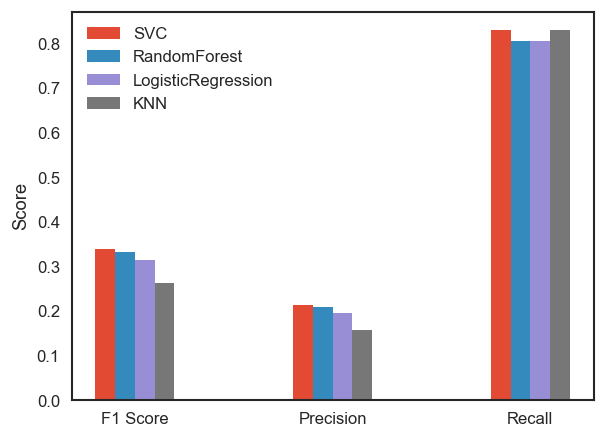

In [1461]:


plt.figure(figsize=(5,4), dpi=120)
plt.bar(x-0.15, svcs, width = 0.1, label='SVC')
plt.bar(x-0.05, rfs, width = 0.1, label='RandomForest')
plt.bar(x+0.05, lrs, width = 0.1, label='LogisticRegression')
plt.bar(x+0.15, knns, width = 0.1, label='KNN')
plt.xticks(x, ['F1 Score', 'Precision', 'Recall'])
plt.legend()
plt.ylabel('Score')

### Precision Recall Curve

In [1658]:
pd.DataFrame([precision_curves['RandomForest'], recall_curves['RandomForest']]).to_csv('./test2.csv')

In [1655]:
pd.DataFrame([precision_curves['SVC'], recall_curves['SVC']])

,0,1,2,3,4,5,6,7,8,9,...,575,576,577,578,579,580,581,582,583,584
0,0.070085,0.068493,0.068611,0.068729,0.068847,0.068966,0.069085,0.069204,0.069324,0.069444,...,0.555556,0.625000,0.714286,0.666667,0.600000,0.50000,0.333333,0.50000,1.00000,1.0
1,1.000000,0.975610,0.975610,0.975610,0.975610,0.975610,0.975610,0.975610,0.975610,0.975610,...,0.121951,0.121951,0.121951,0.097561,0.073171,0.04878,0.024390,0.02439,0.02439,0.0


In [1656]:
pd.DataFrame(precision_curves['SVC'], recall_curves['SVC'])

,0
1.000000,0.070085
0.975610,0.068493
0.975610,0.068611
0.975610,0.068729
0.975610,0.068847
0.975610,0.068966
0.975610,0.069085
0.975610,0.069204
0.975610,0.069324
0.975610,0.069444


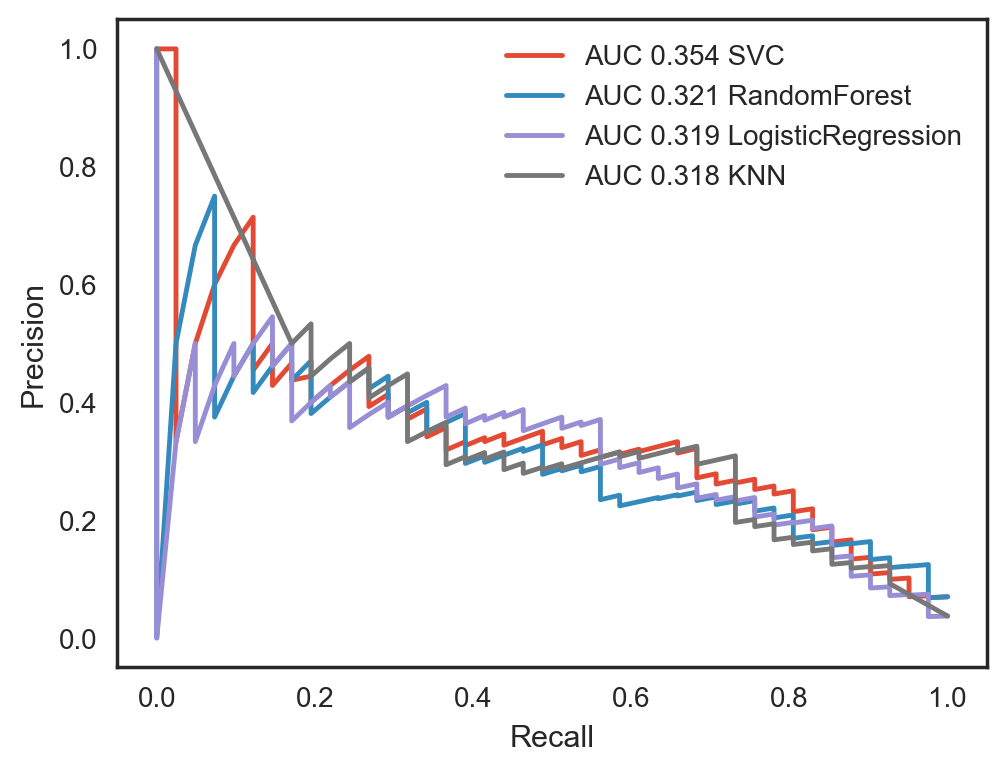

In [1667]:
grids = [gridSVC, gridRF, gridLR, gridKNN]
models = ['SVC', 'RandomForest', 'LogisticRegression', 'KNN']

y_pred_probas = {}
precision_curves = {}
recall_curves = {}
PR_AUC = {}

plt.figure(figsize=(5,4), dpi=200)
plt.xlabel('Recall')
plt.ylabel('Precision')

for model, model_name in zip(grids,models):
    y_pred_probas[model_name] = model.predict_proba(X_test[features_coef.index[:10]])
    PR_AUC[model_name] = average_precision_score(y_test, y_pred_probas[model_name][:,1])
    precision_curves[model_name], recall_curves[model_name], _ = precision_recall_curve(y_test, y_pred_probas[model_name][:,1])
    
    plt.plot(recall_curves[model_name], precision_curves[model_name], label='AUC {:1.3f} {}'.format(PR_AUC[model_name], model_name))
    
plt.legend()

### ROC Curve

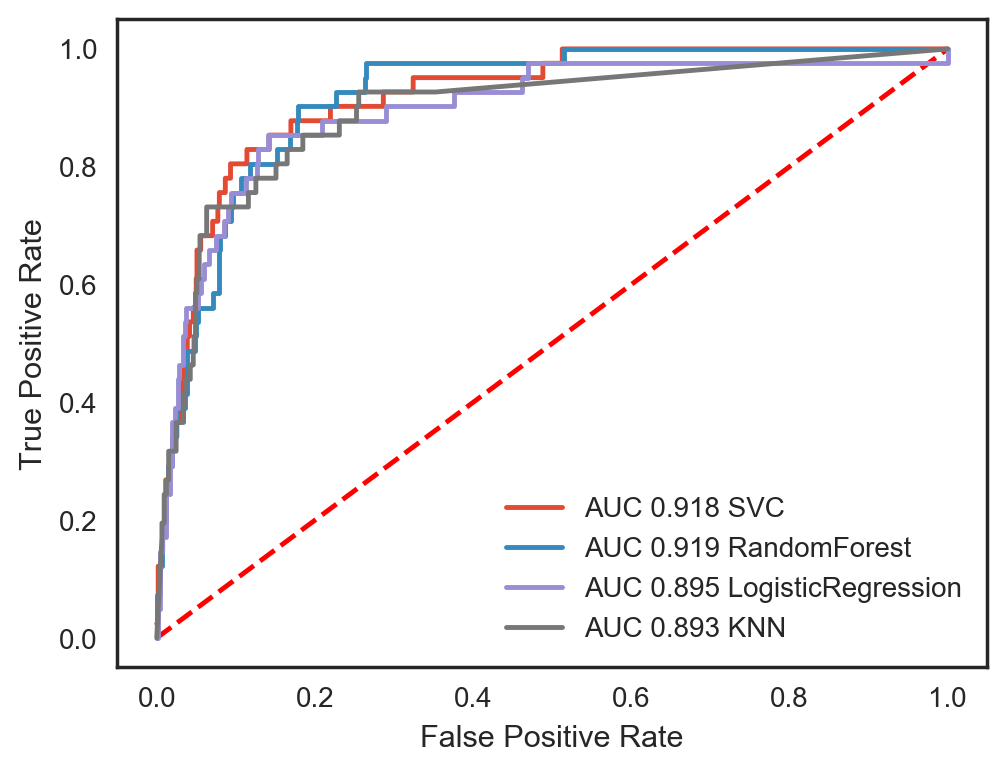

In [1669]:
grids = [gridSVC, gridRF, gridLR, gridKNN]
models = ['SVC', 'RandomForest', 'LogisticRegression', 'KNN']

y_pred_probas = {}
fprs = {}
tprs = {}
PR_ROC = {}

plt.figure(figsize=(5,4), dpi=200)
plt.plot([0,1],[0,1],c='r',ls='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


for model, model_name in zip(grids,models):
    y_pred_probas[model] = model.predict_proba(X_test[features_coef.index[:10]])
    PR_ROC[model] = roc_auc_score(y_test, y_pred_probas[model][:,1])
    fprs[model], tprs[model], _ = roc_curve(y_test, y_pred_probas[model][:,1])
    
    plt.plot(fprs[model], tprs[model], label='AUC {:1.3f} {}'.format(PR_ROC[model], model_name))
    
plt.legend()

### Creating Pipeline & Prediction function

In [1333]:
pipeline_features = list(features_coef.index[:10])
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(gamma=0.05, probability=True, class_weight={1:13}))
])

pipeline.fit(df.iloc[:,3:][pipeline_features], df['Financial Distress'])

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight={1: 13}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [1384]:
df[df['Financial Distress'] == 1].iloc[0,:][pipeline_features]

x16    0.093904
x10   -0.065316
x39    0.203370
x47    6.111400
x57    0.073356
x17    2.058800
x31    7.090900
x28    0.083774
x15    1.638200
x36   -0.017000
Name: 3, dtype: float64

In [1334]:
import pickle

pickle.dump(pipeline, open('model_v1.pkl', 'wb'))

In [1501]:
def bankruptcy_prediction(features):
    X = np.array([features['x16'], (features['x10']), features['x39'], features['x47'], features['x57'], features['x17'], features['x31'], features['x28'], features['x15'], features['x36']]).reshape(1,-1)
    prob_bankruptcy = pipeline.predict_proba(X)[0, 1]
    
    result = {
        'Prediction': ('Financially distressed' if prob_bankruptcy >= 0.5 else 'Healthy'),
        'Bankruptcy Probability': '{:2.1f}%'.format(prob_bankruptcy*100)
    }
    return result